<a href="https://colab.research.google.com/github/Herick-Asmani/Food-101-classification-using-ResNet-50/blob/master/Food101challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Download and Extract Food-101 Dataset**

In [0]:
# Helper function to download data and extract
import os
def get_data():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [2]:
get_data()

Dataset already exists


In [3]:
# Check the contents of the downloaded file
!ls food-101/

images	license_agreement.txt  meta  README.txt  test  train


In [4]:
# Check the contents of images folder
!ls food-101/images

apple_pie	    eggs_benedict	     onion_rings
baby_back_ribs	    escargots		     oysters
baklava		    falafel		     pad_thai
beef_carpaccio	    filet_mignon	     paella
beef_tartare	    fish_and_chips	     pancakes
beet_salad	    foie_gras		     panna_cotta
beignets	    french_fries	     peking_duck
bibimbap	    french_onion_soup	     pho
bread_pudding	    french_toast	     pizza
breakfast_burrito   fried_calamari	     pork_chop
bruschetta	    fried_rice		     poutine
caesar_salad	    frozen_yogurt	     prime_rib
cannoli		    garlic_bread	     pulled_pork_sandwich
caprese_salad	    gnocchi		     ramen
carrot_cake	    greek_salad		     ravioli
ceviche		    grilled_cheese_sandwich  red_velvet_cake
cheesecake	    grilled_salmon	     risotto
cheese_plate	    guacamole		     samosa
chicken_curry	    gyoza		     sashimi
chicken_quesadilla  hamburger		     scallops
chicken_wings	    hot_and_sour_soup	     seaweed_salad
chocolate_cake	    hot_dog		     shrimp_and_grits
chocolate_mousse    huevo

In [5]:
# Check the contents of images folder
!ls food-101/meta

classes.txt  labels.txt  test.json  test.txt  train.json  train.txt


## **Visualize the data**

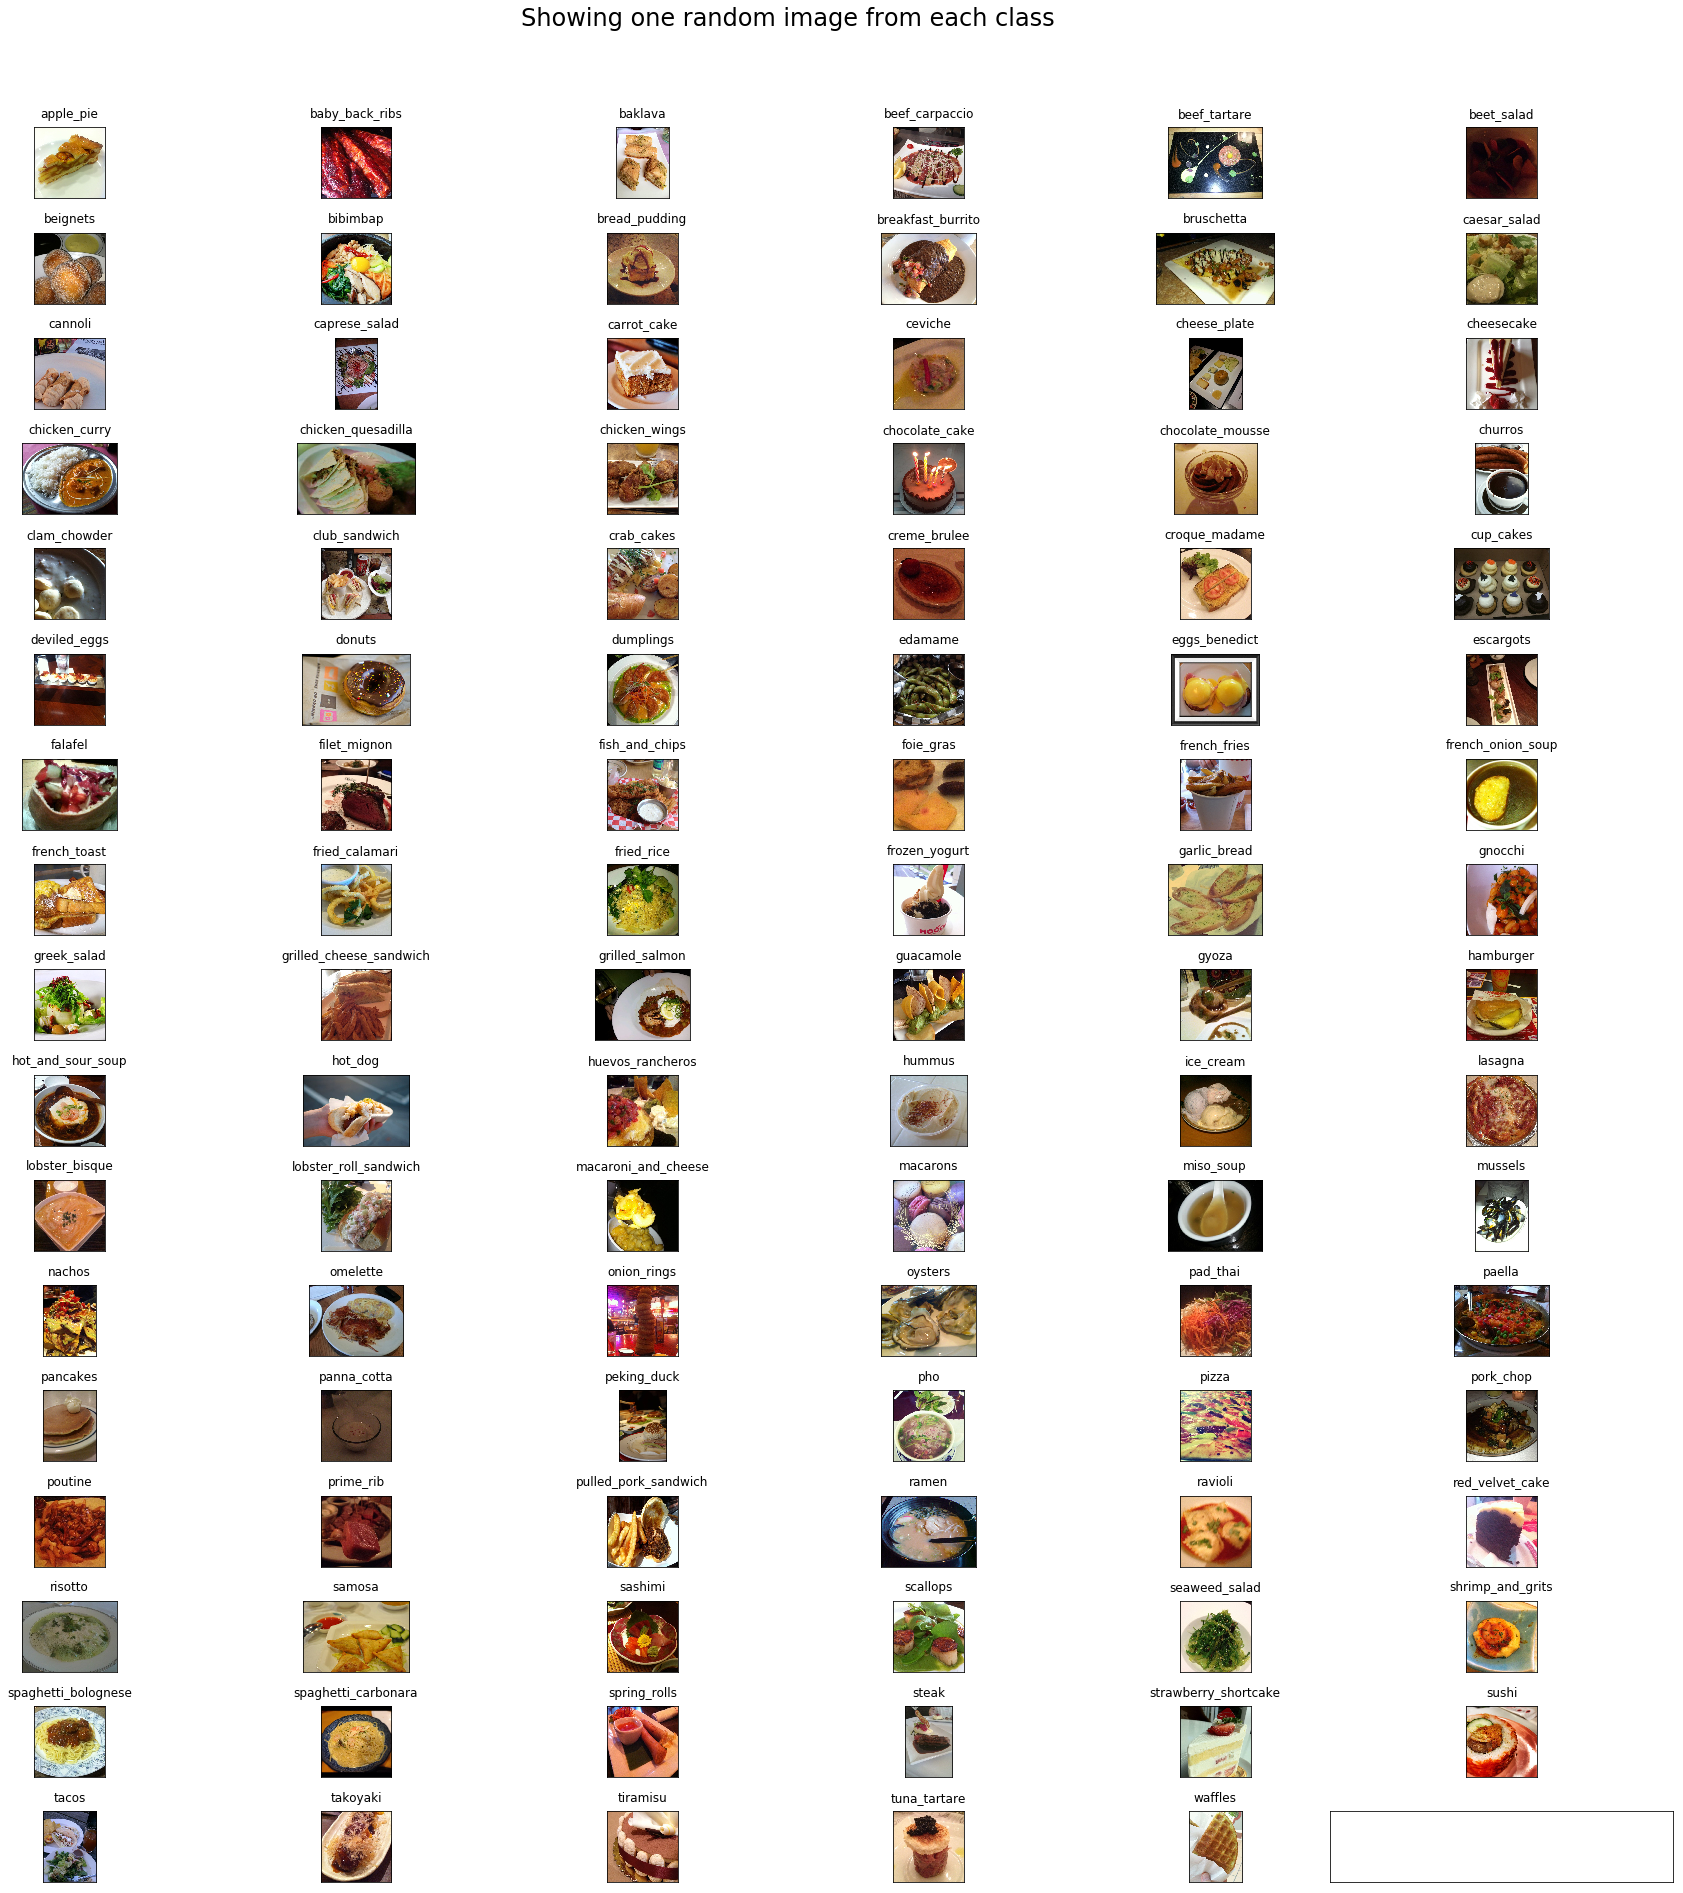

In [3]:

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
import os

# Visualize the data, showing one random image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) 
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()


## Splitting data into train and test sets

In [0]:
# Helper method to split dataset into train and test folders
from shutil import copy
def prepare_data(filepath, src, dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [0]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

In [0]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

In [0]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find food-101/train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [0]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find food-101/test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


## Data Augmentation & Data Exploration

In [0]:
# Import necessary PyTorch libraries
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np


In [5]:
# Check whether GPU is available and if it is then use GPU
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
# Data augmentation
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(45),
                                       transforms.RandomAffine(45),
                                       transforms.ColorJitter(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

# Use 10-crop for Test Time Augmentation
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.TenCrop(224),
                                      transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                      transforms.Lambda(lambda crops: torch.stack([transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(crop) for crop in crops]))])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder("./food-101/train", transform=train_transforms)
test_data = datasets.ImageFolder("./food-101/test", transform=test_transforms)

# Using the image datasets and the tranforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size= 64, shuffle = True)

In [5]:
# print out some data stats
print('Number of training images: ', len(train_data))
print('Number of testing images: ', len(test_data))

with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
print('Number of classes: ', len(classes))    

# Analyzing the shape of one batch
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

print('Shape of first batch of training images: ', train_images.shape)
print('Shape of first batch of test images: ', test_images.shape) # 5-D array because of 10 crops

Number of training images:  75750
Number of testing images:  25250
Number of classes:  101
Shape of first batch of training images:  torch.Size([64, 3, 224, 224])
Shape of first batch of test images:  torch.Size([64, 10, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

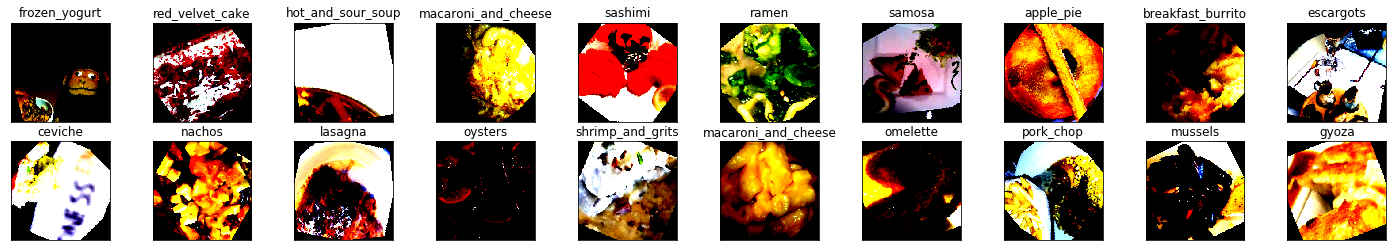

In [6]:
# Visualize some sample training data after Data augmentation

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Model Architecture (ResNet-50)

### ResNet-50 was chosen because challenge itself mentioned ResNet-50 in it. Even though I tried with Inception v3 model but it took a lot of time to train Inception v3 compared to ResNet-50. Also, For this dataset, ResNet-50 converged faster compared to Inception v3. Faster Learning of ResNet is due to Skip Connections which also helps in preventing vanishing gradient problem.



In [11]:
# Load the ResNet-50 model pretraned on ImageNet 
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [12]:
# Freeze the initial layers
for param in model.parameters():
  param.requies_grad = False
  
# Replace the final fully connected layer with new fully connected layer (randomly initialized weights)
# that outputs 101 units (based on our dataset)
classifier = nn.Linear(2048, 101)
model.fc = classifier
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

## **Training (Initial Layers Frozen + Training Only Final Layer)**

### Initially, I used adam as optimizer. However, the model was stucked around 80% for a long time even with learning rate scheduler and more number of epochs were used in that. So, I switched to Stochastic Gradient Descent with momentum where the convergence to 86% was obtained very smoothly and with few number of epochs. With SGD, Learning rate scheduler (ReduceLROnPlateau) played a great role in achieving 86% accuracy.


In [0]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent with momentum)
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

# secify learning rate scheduler (if there is no further decrease in loss for next 5 epochs 
# then lower the learning rate by 0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)

In [0]:
# Move the model to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    train_accuracy = 0.0
    valid_loss = 0.0
    val_accuracy = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # Calculate training accuracy
        top_p, top_class = output.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            
            ## For 10-crop Testing
            input_var = torch.autograd.Variable(data, volatile=True)
            target_var = torch.autograd.Variable(target, volatile=True)
            bs, ncrops, c, h, w = input_var.size()
            # forward pass: compute predicted outputs by passing inputs to the model
            temp_output = model(input_var.view(-1, c, h, w))
            output = temp_output.view(bs, ncrops, -1).mean(1)
            # calculate the batch loss
            loss = criterion(output, target_var)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            # Calculate validation accuracy
            top_p, top_class = output.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
    
    # calculate average losses and accuracies
    train_loss = train_loss/len(train_loader.dataset)
    train_accuracy = train_accuracy/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    val_accuracy = val_accuracy/len(test_loader.dataset)
    # Learning rate scheduler step
    scheduler.step(valid_loss) 
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f}'.format(
        epoch, train_loss, train_accuracy, valid_loss, val_accuracy))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        
        checkpoint = {"model": model,
                      "criterion": criterion,
                      "epochs": epoch,
                      "optimizer_state": optimizer.state_dict(),
                      "model_state": model.state_dict(),
                      "valid_loss_min": valid_loss}
    
        # save model in colab
        torch.save(checkpoint, 'res50_model_checkpoint.pth')
        valid_loss_min = valid_loss

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch: 1 	Training Loss: 3.1898 	Training Accuracy: 0.2719 	Validation Loss: 2.3836 	Validation Accuracy: 0.4230
Validation loss decreased (inf --> 2.383633).  Saving model ...
Epoch: 2 	Training Loss: 2.7653 	Training Accuracy: 0.3443 	Validation Loss: 2.1893 	Validation Accuracy: 0.4586
Validation loss decreased (2.383633 --> 2.189335).  Saving model ...
Epoch: 3 	Training Loss: 2.6916 	Training Accuracy: 0.3607 	Validation Loss: 2.0861 	Validation Accuracy: 0.4750
Validation loss decreased (2.189335 --> 2.086067).  Saving model ...
Epoch: 4 	Training Loss: 2.6386 	Training Accuracy: 0.3757 	Validation Loss: 2.0440 	Validation Accuracy: 0.4835
Validation loss decreased (2.086067 --> 2.044021).  Saving model ...
Epoch: 5 	Training Loss: 2.6076 	Training Accuracy: 0.3825 	Validation Loss: 2.0218 	Validation Accuracy: 0.4896
Validation loss decreased (2.044021 --> 2.021769).  Saving model ...
Epoch: 6 	Training Loss: 2.5925 	Training Accuracy: 0.3850 	Validation Loss: 2.0017 	Validation

In [0]:
# Due to Colab's connection timeout, loading and training the model from the last epoch.

In [0]:
# Load the saved model from last checkpoint
checkpoint = torch.load("./res50_model_checkpoint (1).pth", map_location='cpu')

# Use the same architecture as used earlier
model = models.resnet50(pretrained=False)
for param in model.parameters():
  param.requires_grad = False

    
classifier = nn.Linear(2048, 101)
model.fc = classifier

model.load_state_dict(checkpoint['model_state'], strict=False)

# specify loss function (categorical cross-entropy) same as used earlier
criterion = nn.CrossEntropyLoss()

# specify optimizer same as used earlier
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

# secify scheduler same as used earlier
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)

# Check the saved model's last epoch and last validation loss
valid_loss = checkpoint["valid_loss_min"] 
num_epoch = checkpoint['epochs']

In [0]:
print(num_epoch)
print(valid_loss)

9
1.9544203061774226


In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········


In [0]:
# Move the model to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

# number of epochs to train the model
n_epochs = 20

valid_loss_min = valid_loss # track change in validation loss

for epoch in range(num_epoch+1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    train_accuracy = 0.0
    valid_loss = 0.0
    val_accuracy = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # Calculate training accuracy
        top_p, top_class = output.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            
            ## For 10-crop Testing
            input_var = torch.autograd.Variable(data, volatile=True)
            target_var = torch.autograd.Variable(target, volatile=True)
            bs, ncrops, c, h, w = input_var.size()
            # forward pass: compute predicted outputs by passing inputs to the model
            temp_output = model(input_var.view(-1, c, h, w))
            output = temp_output.view(bs, ncrops, -1).mean(1)
            # calculate the batch loss
            loss = criterion(output, target_var)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            # Calculate validation accuracy
            top_p, top_class = output.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    train_accuracy = train_accuracy/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    val_accuracy = val_accuracy/len(test_loader.dataset)
    scheduler.step(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f}'.format(
        epoch, train_loss, train_accuracy, valid_loss, val_accuracy))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        
        checkpoint = {"model": model,
                      "criterion": criterion,
                      "epochs": epoch,
                      "optimizer_state": optimizer.state_dict(),
                      "model_state": model.state_dict(),
                      "valid_loss_min": valid_loss}
        
        # Save model to google drive
        model_save_name = 'resnet50model.pth'
        path = F"/content/gdrive/My Drive/{model_save_name}" 
        torch.save(checkpoint, path)
        
        # Save model in colab only
        torch.save(checkpoint, 'res50_model_checkpoint.pth')
        valid_loss_min = valid_loss

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch: 10 	Training Loss: 2.5216 	Training Accuracy: 0.3973 	Validation Loss: 1.9490 	Validation Accuracy: 0.5023
Validation loss decreased (1.954420 --> 1.948977).  Saving model ...
Epoch: 11 	Training Loss: 2.5094 	Training Accuracy: 0.4007 	Validation Loss: 1.9857 	Validation Accuracy: 0.4950
Epoch: 12 	Training Loss: 2.5001 	Training Accuracy: 0.4034 	Validation Loss: 1.9227 	Validation Accuracy: 0.5152
Validation loss decreased (1.948977 --> 1.922666).  Saving model ...
Epoch: 13 	Training Loss: 2.4853 	Training Accuracy: 0.4047 	Validation Loss: 1.8991 	Validation Accuracy: 0.5191
Validation loss decreased (1.922666 --> 1.899093).  Saving model ...
Epoch: 14 	Training Loss: 2.4756 	Training Accuracy: 0.4084 	Validation Loss: 1.8489 	Validation Accuracy: 0.5248
Validation loss decreased (1.899093 --> 1.848872).  Saving model ...
Epoch: 15 	Training Loss: 2.4729 	Training Accuracy: 0.4065 	Validation Loss: 1.9524 	Validation Accuracy: 0.5008
Epoch: 16 	Training Loss: 2.4606 	Traini

## Training the entire network (Unfreeze Initial Layers + Use Final Layer's previously Trained Weights)

In [0]:
# Load the saved model from last checkpoint
checkpoint = torch.load("./gdrive/My Drive/resnet50model.pth", map_location='cpu')

# Use entire network for training
model = models.resnet50(pretrained=False)
# for param in model.parameters():
#   param.requires_grad = False

    
classifier = nn.Linear(2048, 101)
model.fc = classifier

model.load_state_dict(checkpoint['model_state'], strict=False)

# specify loss function (categorical cross-entropy) same as used earlier
criterion = nn.CrossEntropyLoss()

# specify optimizer same as used earlier
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# secify scheduler same as used earlier
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)

# Check the saved model's last epoch and last validation loss
valid_loss = checkpoint["valid_loss_min"] 
num_epoch = checkpoint['epochs']

In [0]:
print(num_epoch)
print(valid_loss)


16
1.1335798953311278


In [0]:
# Move the model to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

# number of epochs to train the model 
n_epochs = 65  # new number of epochs

valid_loss_min = valid_loss # track change in validation loss

for epoch in range(num_epoch+1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    train_accuracy = 0.0
    valid_loss = 0.0
    val_accuracy = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # Calculate training accuracy
        top_p, top_class = output.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            
            ## For 10-crop Testing
            input_var = torch.autograd.Variable(data, volatile=True)
            target_var = torch.autograd.Variable(target, volatile=True)
            bs, ncrops, c, h, w = input_var.size()
            # forward pass: compute predicted outputs by passing inputs to the model
            temp_output = model(input_var.view(-1, c, h, w))
            output = temp_output.view(bs, ncrops, -1).mean(1)
            # calculate the batch loss
            loss = criterion(output, target_var)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            # Calculate validation accuracy
            top_p, top_class = output.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    train_accuracy = train_accuracy/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    val_accuracy = val_accuracy/len(test_loader.dataset)
    scheduler.step(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f}'.format(
        epoch, train_loss, train_accuracy, valid_loss, val_accuracy))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        
        checkpoint = {"model": model,
                      "criterion": criterion,
                      "epochs": epoch,
                      "optimizer_state": optimizer.state_dict(),
                      "model_state": model.state_dict(),
                      "valid_loss_min": valid_loss}
        
        # Save model to google drive
        model_save_name = 'resnet50model.pth'
        path = F"/content/gdrive/My Drive/{model_save_name}" 
        torch.save(checkpoint, path)
        
        # Save model in colab only
    
        torch.save(checkpoint, 'res50_model_checkpoint.pth')
        valid_loss_min = valid_loss

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch: 17 	Training Loss: 1.6715 	Training Accuracy: 0.5774 	Validation Loss: 1.0857 	Validation Accuracy: 0.7053
Validation loss decreased (1.133580 --> 1.085669).  Saving model ...
Epoch: 18 	Training Loss: 1.5652 	Training Accuracy: 0.6011 	Validation Loss: 1.0972 	Validation Accuracy: 0.7040
Epoch: 19 	Training Loss: 1.4875 	Training Accuracy: 0.6205 	Validation Loss: 0.9679 	Validation Accuracy: 0.7392
Validation loss decreased (1.085669 --> 0.967892).  Saving model ...
Epoch: 20 	Training Loss: 1.4213 	Training Accuracy: 0.6358 	Validation Loss: 0.9016 	Validation Accuracy: 0.7528
Validation loss decreased (0.967892 --> 0.901609).  Saving model ...
Epoch: 21 	Training Loss: 1.3680 	Training Accuracy: 0.6490 	Validation Loss: 0.8747 	Validation Accuracy: 0.7600
Validation loss decreased (0.901609 --> 0.874674).  Saving model ...
Epoch: 22 	Training Loss: 1.3019 	Training Accuracy: 0.6629 	Validation Loss: 0.8609 	Validation Accuracy: 0.7608
Validation loss decreased (0.874674 --> 

In [0]:
# Load the saved model from last checkpoint
checkpoint = torch.load("./gdrive/My Drive/resnet50model.pth", map_location='cpu')

# Use entire network for training
model = models.resnet50(pretrained=False)
# for param in model.parameters():
#   param.requires_grad = False

    
classifier = nn.Linear(2048, 101)
model.fc = classifier

model.load_state_dict(checkpoint['model_state'], strict=False)

# specify loss function (categorical cross-entropy) same as used earlier
criterion = nn.CrossEntropyLoss()

# specify optimizer same as used earlier
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# secify scheduler same as used earlier
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)

# Check the saved model's last epoch and last validation loss
valid_loss = checkpoint["valid_loss_min"] 
num_epoch = checkpoint['epochs']

In [0]:
print(num_epoch)
print(valid_loss)


26
0.6908938096631871


In [0]:
# Move the model to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

# number of epochs to train the model 
n_epochs = 65

valid_loss_min = valid_loss # track change in validation loss

for epoch in range(num_epoch+1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    train_accuracy = 0.0
    valid_loss = 0.0
    val_accuracy = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # Calculate training accuracy
        top_p, top_class = output.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            
            ## For 10-crop Testing
            input_var = torch.autograd.Variable(data, volatile=True)
            target_var = torch.autograd.Variable(target, volatile=True)
            bs, ncrops, c, h, w = input_var.size()
            # forward pass: compute predicted outputs by passing inputs to the model
            temp_output = model(input_var.view(-1, c, h, w))
            output = temp_output.view(bs, ncrops, -1).mean(1)
            # calculate the batch loss
            loss = criterion(output, target_var)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            # Calculate validation accuracy
            top_p, top_class = output.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    train_accuracy = train_accuracy/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    val_accuracy = val_accuracy/len(test_loader.dataset)
    scheduler.step(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f}'.format(
        epoch, train_loss, train_accuracy, valid_loss, val_accuracy))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        
        checkpoint = {"model": model,
                      "criterion": criterion,
                      "epochs": epoch,
                      "optimizer_state": optimizer.state_dict(),
                      "model_state": model.state_dict(),
                      "valid_loss_min": valid_loss}
        
        # Save model to google drive
        model_save_name = 'resnet50model.pth'
        path = F"/content/gdrive/My Drive/{model_save_name}" 
        torch.save(checkpoint, path)
        
        # Save model in colab only
    
        torch.save(checkpoint, 'res50_model_checkpoint.pth')
        valid_loss_min = valid_loss

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch: 27 	Training Loss: 1.1282 	Training Accuracy: 0.7031 	Validation Loss: 0.7227 	Validation Accuracy: 0.8016
Epoch: 28 	Training Loss: 1.1082 	Training Accuracy: 0.7089 	Validation Loss: 0.6553 	Validation Accuracy: 0.8184
Validation loss decreased (0.690894 --> 0.655334).  Saving model ...
Epoch: 29 	Training Loss: 1.0813 	Training Accuracy: 0.7143 	Validation Loss: 0.7159 	Validation Accuracy: 0.8008
Epoch: 30 	Training Loss: 1.0574 	Training Accuracy: 0.7215 	Validation Loss: 0.7190 	Validation Accuracy: 0.8021
Epoch: 31 	Training Loss: 1.0322 	Training Accuracy: 0.7258 	Validation Loss: 0.7334 	Validation Accuracy: 0.7949
Epoch: 32 	Training Loss: 1.0126 	Training Accuracy: 0.7298 	Validation Loss: 0.6200 	Validation Accuracy: 0.8280
Validation loss decreased (0.655334 --> 0.620012).  Saving model ...
Epoch: 33 	Training Loss: 0.9856 	Training Accuracy: 0.7367 	Validation Loss: 0.6828 	Validation Accuracy: 0.8125
Epoch: 34 	Training Loss: 0.9601 	Training Accuracy: 0.7432 	Val

In [0]:
# Load the saved model from last checkpoint
checkpoint = torch.load("./gdrive/My Drive/resnet50model.pth", map_location='cpu')

# Use entire network for training
model = models.resnet50(pretrained=False)
# for param in model.parameters():
#   param.requires_grad = False

    
classifier = nn.Linear(2048, 101)
model.fc = classifier

model.load_state_dict(checkpoint['model_state'], strict=False)

# specify loss function (categorical cross-entropy) same as used earlier
criterion = nn.CrossEntropyLoss()

# specify optimizer same as used earlier
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# secify scheduler same as used earlier
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)

# Check the saved model's last epoch and last validation loss
valid_loss = checkpoint["valid_loss_min"] 
num_epoch = checkpoint['epochs']

In [0]:
print(num_epoch)
print(valid_loss)
print(checkpoint["optimizer_state"])

In [0]:
# specify optimizer with new learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [0]:
# Move the model to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

# number of epochs to train the model 
n_epochs = 65

valid_loss_min = valid_loss # track change in validation loss

for epoch in range(num_epoch+1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    train_accuracy = 0.0
    valid_loss = 0.0
    val_accuracy = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # Calculate training accuracy
        top_p, top_class = output.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            
            ## For 10-crop Testing
            input_var = torch.autograd.Variable(data, volatile=True)
            target_var = torch.autograd.Variable(target, volatile=True)
            bs, ncrops, c, h, w = input_var.size()
            # forward pass: compute predicted outputs by passing inputs to the model
            temp_output = model(input_var.view(-1, c, h, w))
            output = temp_output.view(bs, ncrops, -1).mean(1)
            # calculate the batch loss
            loss = criterion(output, target_var)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            # Calculate validation accuracy
            top_p, top_class = output.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    train_accuracy = train_accuracy/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    val_accuracy = val_accuracy/len(test_loader.dataset)
    scheduler.step(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f}'.format(
        epoch, train_loss, train_accuracy, valid_loss, val_accuracy))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        
        checkpoint = {"model": model,
                      "criterion": criterion,
                      "epochs": epoch,
                      "optimizer_state": optimizer.state_dict(),
                      "model_state": model.state_dict(),
                      "valid_loss_min": valid_loss}
        
        # Save model to google drive
        model_save_name = 'resnet50model.pth'
        path = F"/content/gdrive/My Drive/{model_save_name}" 
        torch.save(checkpoint, path)
        
        # Save model in colab only
    
        torch.save(checkpoint, 'res50_model_checkpoint.pth')
        valid_loss_min = valid_loss

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch: 41 	Training Loss: 0.6156 	Training Accuracy: 0.8337 	Validation Loss: 0.5305 	Validation Accuracy: 0.8613
Validation loss decreased (0.533256 --> 0.530525).  Saving model ...
Epoch: 42 	Training Loss: 0.5944 	Training Accuracy: 0.8377 	Validation Loss: 0.5303 	Validation Accuracy: 0.8627
Validation loss decreased (0.530525 --> 0.530282).  Saving model ...
Epoch: 43 	Training Loss: 0.5798 	Training Accuracy: 0.8419 	Validation Loss: 0.5367 	Validation Accuracy: 0.8628
Epoch: 44 	Training Loss: 0.5659 	Training Accuracy: 0.8445 	Validation Loss: 0.5458 	Validation Accuracy: 0.8623
Epoch: 45 	Training Loss: 0.5597 	Training Accuracy: 0.8487 	Validation Loss: 0.5512 	Validation Accuracy: 0.8604
Epoch: 46 	Training Loss: 0.5508 	Training Accuracy: 0.8509 	Validation Loss: 0.5306 	Validation Accuracy: 0.8643
Epoch: 47 	Training Loss: 0.5398 	Training Accuracy: 0.8535 	Validation Loss: 0.5437 	Validation Accuracy: 0.8627
Epoch: 48 	Training Loss: 0.5383 	Training Accuracy: 0.8540 	Val

## Testing (with 10-crops augmentation)
### As the model didn't improve for 13 epochs even with learning rate scheduler so finalizing the model obtained at epoch 42

In [0]:
# Load the Final saved model
checkpoint = torch.load("./gdrive/My Drive/resnet50model.pth", map_location='cpu')

model = models.resnet50(pretrained=False)

classifier = nn.Linear(2048, 101)
model.fc = classifier

model.load_state_dict(checkpoint['model_state'], strict=False)

# specify loss function (categorical cross-entropy) same as used earlier
criterion = nn.CrossEntropyLoss()

In [18]:
# Create list of class names
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

#move model to gpu
model.cuda()
model.eval()

# iterate over test data
with torch.no_grad():
  for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
            
      ## For 10-crop Testing
      bs, ncrops, c, h, w = data.size()
      # forward pass: compute predicted outputs by passing inputs to the model
      temp_output = model(data.view(-1, c, h, w))
      output = temp_output.view(bs, ncrops, -1).mean(1)
      # calculate the batch loss
      loss = criterion(output, target)
      # update average test loss 
      test_loss += loss.item()*data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)    
      # compare predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
      # calculate test accuracy for each object class
      for i in range(len(target)):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1
    
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %.2f%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i],
                                                         np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.2f%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
                                                      np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.530282

Test Accuracy of apple_pie: 71.60% (179/250)
Test Accuracy of baby_back_ribs: 77.20% (193/250)
Test Accuracy of baklava: 91.60% (229/250)
Test Accuracy of beef_carpaccio: 92.80% (232/250)
Test Accuracy of beef_tartare: 90.00% (225/250)
Test Accuracy of beet_salad: 84.80% (212/250)
Test Accuracy of beignets: 89.20% (223/250)
Test Accuracy of bibimbap: 93.60% (234/250)
Test Accuracy of bread_pudding: 65.20% (163/250)
Test Accuracy of breakfast_burrito: 75.60% (189/250)
Test Accuracy of bruschetta: 80.40% (201/250)
Test Accuracy of caesar_salad: 90.80% (227/250)
Test Accuracy of cannoli: 93.60% (234/250)
Test Accuracy of caprese_salad: 89.20% (223/250)
Test Accuracy of carrot_cake: 85.20% (213/250)
Test Accuracy of ceviche: 79.20% (198/250)
Test Accuracy of cheesecake: 92.80% (232/250)
Test Accuracy of cheese_plate: 73.60% (184/250)
Test Accuracy of chicken_curry: 80.00% (200/250)
Test Accuracy of chicken_quesadilla: 83.60% (209/250)
Test Accuracy of chicken_wings: 88